# Quantum. Lab 3

Author:
- **Nikita Makarevich (Student ID: 153989)**

## Imports and Utilities

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
import qiskit.visualization as qvis
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass


# selection of quantum simulator (or processor)
backend = Aer.get_backend("qasm_simulator")

In [ ]:
def plot_circuit(circuit: QuantumCircuit, *, ax: plt.Axes | None = None) -> plt.Axes:
    if ax is None:
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(111)
    circuit.draw("mpl", ax=ax)
    return ax


def plot_circuit_and_results(circuit: QuantumCircuit, counts: list[dict]):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_circuit(circuit, ax=axs[0])
    qvis.plot_histogram(
        counts,
        ax=axs[1],
    )
    qvis.plot_distribution(
        counts,
        legend=[f"Execution {i + 1}" for i in range(len(counts))],
        ax=axs[2],
    )
    axs[0].set_title("Circuit")
    axs[1].set_title("Distribution [counts]")
    axs[2].set_title("Probabilities")


def run_experiments(
    backend, circuit: QuantumCircuit, *, shots: int = 2048, runs: int = 3
) -> list[dict]:
    compiled_circuit = transpile(circuit, backend)
    return [
        backend.run(compiled_circuit, shots=shots).result().get_counts()
        for _ in range(runs)
    ]

## Creating circuit

In [18]:
@dataclass
class Setup:
    n: int
    qx: QuantumRegister
    cx: ClassicalRegister
    circuit: QuantumCircuit

    @classmethod
    def create(cls) -> "Setup":
        n = 4
        qx = QuantumRegister(n, "q")
        cx = ClassicalRegister(n, "c")
        circ = QuantumCircuit(qx, cx)
        return cls(n, qx, cx, circ)

In [19]:
def connect_reset_states(setup: Setup) -> None:
    for i in range(setup.n):
        setup.circuit.reset(setup.qx[i])


def connect_generate_random_number(setup: Setup, qbit: int) -> None:
    setup.circuit.h(setup.qx[qbit])
    setup.circuit.measure(setup.qx[qbit], setup.cx[qbit])


def connect_barrier(setup: Setup) -> None:
    qbits = [setup.qx[i] for i in range(setup.n)]
    setup.circuit.barrier(*qbits)


def connect_code_info(
    setup: Setup, data_qbit: int, basis_qbit: int, output_qbit: int
) -> None:
    setup.circuit.cx(setup.qx[data_qbit], setup.qx[output_qbit])
    setup.circuit.ch(setup.qx[basis_qbit], setup.qx[output_qbit])


def connect_decode_info(setup: Setup, data_qbit: int, basis_qbit: int) -> None:
    setup.circuit.ch(setup.qx[basis_qbit], setup.qx[data_qbit])
    setup.circuit.measure(setup.qx[data_qbit], setup.cx[data_qbit])

In [20]:
setup = Setup.create()
connect_reset_states(setup)

# Alice
connect_generate_random_number(setup, qbit=1)
connect_generate_random_number(setup, qbit=2)
connect_barrier(setup)
connect_code_info(setup, data_qbit=1, basis_qbit=2, output_qbit=0)
connect_barrier(setup)

# Bob
connect_generate_random_number(setup, qbit=3)
connect_barrier(setup)
connect_decode_info(setup, data_qbit=0, basis_qbit=3)

<Axes: >

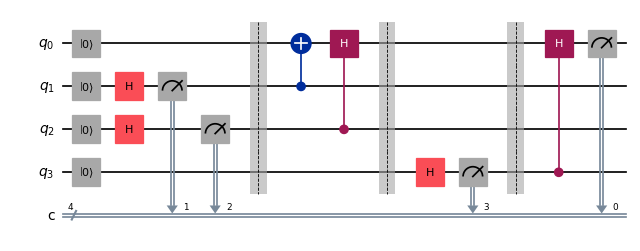

In [26]:
plot_circuit(setup.circuit)

## Running experiments

In [ ]:
def run_key_length_test(sample_size: int = 10) -> int:
    results = run_experiments(backend, setup.circuit, shots=1, runs=sample_size)
    secret_key = []
    for result in results:
        output_bits_str = list(result.keys())[0]
        output_bits = [int(bit) for bit in output_bits_str[::-1]]
        if output_bits[2] == output_bits[3]:
            secret_key.append(output_bits[0])
    return len(secret_key)


sample_sizes = [16, 32, 64, 128, 256]
n_tests = 5
key_lengths: list[list[int]] = []
for sample_size in sample_sizes:
    key_lengths.append(
        [run_key_length_test(sample_size=sample_size) for _ in range(n_tests)]
    )

pd.DataFrame(
    key_lengths,
    index=pd.Index(sample_sizes, name="n_bits_for_encoding"),
    columns=[f"Test {i + 1}" for i in range(n_tests)],
)

,Test 1,Test 2,Test 3,Test 4,Test 5
n_bits_for_encoding,,,,,
16,10,8,10,5,8
32,15,15,18,17,17
64,33,35,33,27,39
128,63,60,64,70,64
256,141,123,138,122,118
